In [55]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.plot_data as plot
import models.transforms as transforms
import algorithms.teaching_algs as algs
from evals.teaching_evals import *
import utils.gen_triplets as gen

sns.set_theme()
def get_ci(samples, confidence=0.95):  return stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)

def get_lpips_data(dataset, seeds, sim=True):    
    transform = transforms.bird_transform()
    train = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/train", transform=transform)
    test = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/test", transform=transform)
    x_train = np.array([x[0].numpy() for x in train])
    x_test = np.array([x[0].numpy() for x in test])
    y_train = np.array([x[1] for x in train])
    y_test = np.array([x[1] for x in test])

    dist_M = pickle.load(open(f"data/dist/lpips/{dataset}/train_test.pkl","rb"))
    dist_M = dist2sim(dist_M) if sim else dist_M
    zs = [pickle.load(open(f"data/embeds/bm_lpips/TN_train_d50_seed{seed}.pkl","rb")) for seed in seeds]

    return dist_M, zs, y_train, y_test

def get_prolific_data(dataset, seeds, sim=True):    
    transform = transforms.bird_transform()
    train = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/train", transform=transform)
    test = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/test", transform=transform)
    x_train = np.array([x[0].numpy() for x in train])
    x_test = np.array([x[0].numpy() for x in test])
    y_train = np.array([x[1] for x in train])
    y_test = np.array([x[1] for x in test])

    dist_Ms = [pickle.load(open(f"data/dist/prolific/{dataset}/train_test_seed{seed}.pkl","rb")) for seed in seeds]
    dist_Ms = [dist2sim(m) if sim else m for m in dist_Ms]
    zs = [pickle.load(open(f"data/embeds/{dataset}_prolific/TN_train_d50_seed{seed}.pkl","rb")) for seed in seeds]

    return dist_Ms, zs, y_train, y_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## contrative voting experiments

#### fixed teaching algorithm

In [5]:
def random_experiments(m_range, dist_M, y_train, y_test, sim=True):
    results = {
        '1NN': random_1NN(m_range, dist_M, y_train, y_test, sim=sim),
        '1NN_double': random_1NN(m_range*2, dist_M, y_train, y_test, sim=sim),
        'exemplar': random_exemplar(m_range, dist_M, y_train, y_test, sim=sim),
        'CV': random_CV(m_range, dist_M, y_train, y_test, weight=None, sim=sim),
        'CV_w=dist': random_CV(m_range, dist_M, y_train, y_test, weight='sim', sim=sim),
        'CV_w=ddiff': random_CV(m_range, dist_M, y_train, y_test, weight='abs', sim=sim),
    }
    return results

def full_experiments(m_range, dist_M, y_train, y_test, sim=True):
    results = {
        '1NN': full_1NN(m_range, dist_M, y_train, y_test, sim=sim),
        '1NN_double': full_1NN(m_range*2, dist_M, y_train, y_test, sim=sim),
        'exemplar': full_exemplar(m_range, dist_M, y_train, y_test, sim=sim),
        'CV': full_CV(m_range, dist_M, y_train, y_test, weight=None, sim=sim),
        'CV_w=dist': full_CV(m_range, dist_M, y_train, y_test, weight='sim', sim=sim),
        'CV_w=ddiff': full_CV(m_range, dist_M, y_train, y_test, weight='abs', sim=sim),
    }
    return results

def teaching_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=True):
    nn, nn_double, exemplar, CV, CV_w, CV_abs = np.zeros(len(m_range)), np.zeros(len(m_range)), np.zeros(len(m_range)), np.zeros(len(m_range)), np.zeros(len(m_range)), np.zeros(len(m_range))

    paired_z, idx = paired_z
    for j, m in enumerate(m_range):
        S_concat = alg(paired_z, m)
        S_pairs = idx[S_concat]
        S_single = alg(z, m)
        S_double = alg(z, m*2)
        nn[j] = eval_KNN(dist_M, S_single, y_train, y_test, sim=sim)
        nn_double[j] = eval_KNN(dist_M, S_double, y_train, y_test, sim=sim)
        exemplar[j] = eval_exemplar(dist_M, S_single, y_train, y_test, sim=sim)
        CV[j] = eval_CV(dist_M, S_pairs, y_train, y_test, weight=None, sim=sim)
        CV_w[j] = eval_CV(dist_M, S_pairs, y_train, y_test, weight='sim', sim=sim)
        CV_abs[j] = eval_CV(dist_M, S_pairs, y_train, y_test, weight='abs', sim=sim)
    
    results = {
        '1NN': nn,
        '1NN_double': nn_double,
        'exemplar': exemplar,
        'CV': CV,
        'CV_w=dist': CV_w,
        'CV_w=ddiff': CV_abs,
    }
    return results

In [2]:
m_range = np.arange(1, 40)

In [3]:
dataset = "bm"
seeds = np.arange(10)
SIM = True
dist_M, zs, y_train, y_test = get_lpips_data(dataset, seeds, sim=SIM)

In [6]:
random_acc = random_experiments(m_range, dist_M, y_train, y_test, sim=SIM)
full_acc = full_experiments(m_range, dist_M, y_train, y_test, sim=SIM)

In [31]:
alg = algs.mmd_greedy
paired_zs = [concat_embeds(z, y_train) for z in zs]

teaching_results = [teaching_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z in zip(paired_zs, zs)]
teaching_acc = {key:np.mean(np.array([result[key] for result in teaching_results]), axis=0) for key in teaching_results[0].keys()}
teaching_ste = {key: get_ci(np.array([result[key] for result in teaching_results])) for key in teaching_results[0].keys()}

In [96]:
np.round(1.5555, 3)

1.556

In [66]:
sns.set_color_codes("bright")
LINE_WIDTH = 2.5
MARKER_SIZE = 8
plot_configs = {     "1NN":                     {'c':"c", 'lw':LINE_WIDTH, 'ls':"solid", 'marker':"", 'ms':MARKER_SIZE, }, 
                        "1NN_double":           {'c':"b", 'lw':LINE_WIDTH, 'ls':"solid", 'marker':"", 'ms':MARKER_SIZE, },
                        "exemplar":             {'c':"y", 'lw':LINE_WIDTH, 'ls':"dashdot", 'marker':"o", 'ms':MARKER_SIZE, },
                        "CV":           {'c':"r", 'lw':LINE_WIDTH, 'ls':"solid", 'marker':"s", 'ms':MARKER_SIZE, },
                        "CV_w=dist":           {'c':"g", 'lw':LINE_WIDTH, 'ls':"dotted", 'marker':"^", 'ms':MARKER_SIZE, },
                        "CV_w=ddiff":           {'c':"m", 'lw':LINE_WIDTH, 'ls':"solid", 'marker':"x", 'ms':MARKER_SIZE, },
                        }

def plot_random(results, m_range, title, ste=None):
    plt.figure(figsize=(14,8))
    for key in results.keys():
        config = plot_configs[key]
        plt.errorbar(m_range, results[key], yerr=ste, alpha=0.7, **config)

    plt.xticks(m_range)
    plt.xlabel("m")
    bot, top = plt.ylim()
    plt.yticks(np.arange(bot,top, (top-bot)/10))
    plt.legend(results.keys(), loc="lower center", ncol=len(results))
    plt.title(title)
    plt.show()

def plot_full(results, m_range, title):
    plt.figure(figsize=(14,8))
    plt.bar(list(results.keys()), [v[0] for v in results.values()], width=0.5)
    bot, top = plt.ylim()
    plt.yticks(np.arange(bot,top,0.05))
    plt.title(title)
    plt.show()

def plot_teaching(results, m_range, title, ste=None, idx=None):
    plt.figure(figsize=(14,8))
    m_range = m_range[idx] if idx is not None else m_range
    for key in results.keys():
        config = plot_configs[key]
        result = results[key][idx] if idx is not None else results[key]
        plt.plot(m_range, result,alpha=0.8, **config)
        if ste is not None:
            yerr = ste[key][idx]/2 if idx is not None else ste[key]/2
            plt.errorbar(m_range, result, yerr=yerr, alpha=0.5,elinewidth=LINE_WIDTH/2, **config)

    plt.xticks(m_range)
    plt.xlabel("m")
    bot, top = plt.ylim()
    plt.yticks(np.arange(bot,top, (top-bot)/10))
    plt.legend(results.keys(), loc="lower center", ncol=len(results))
    plt.title(title)
    plt.show()

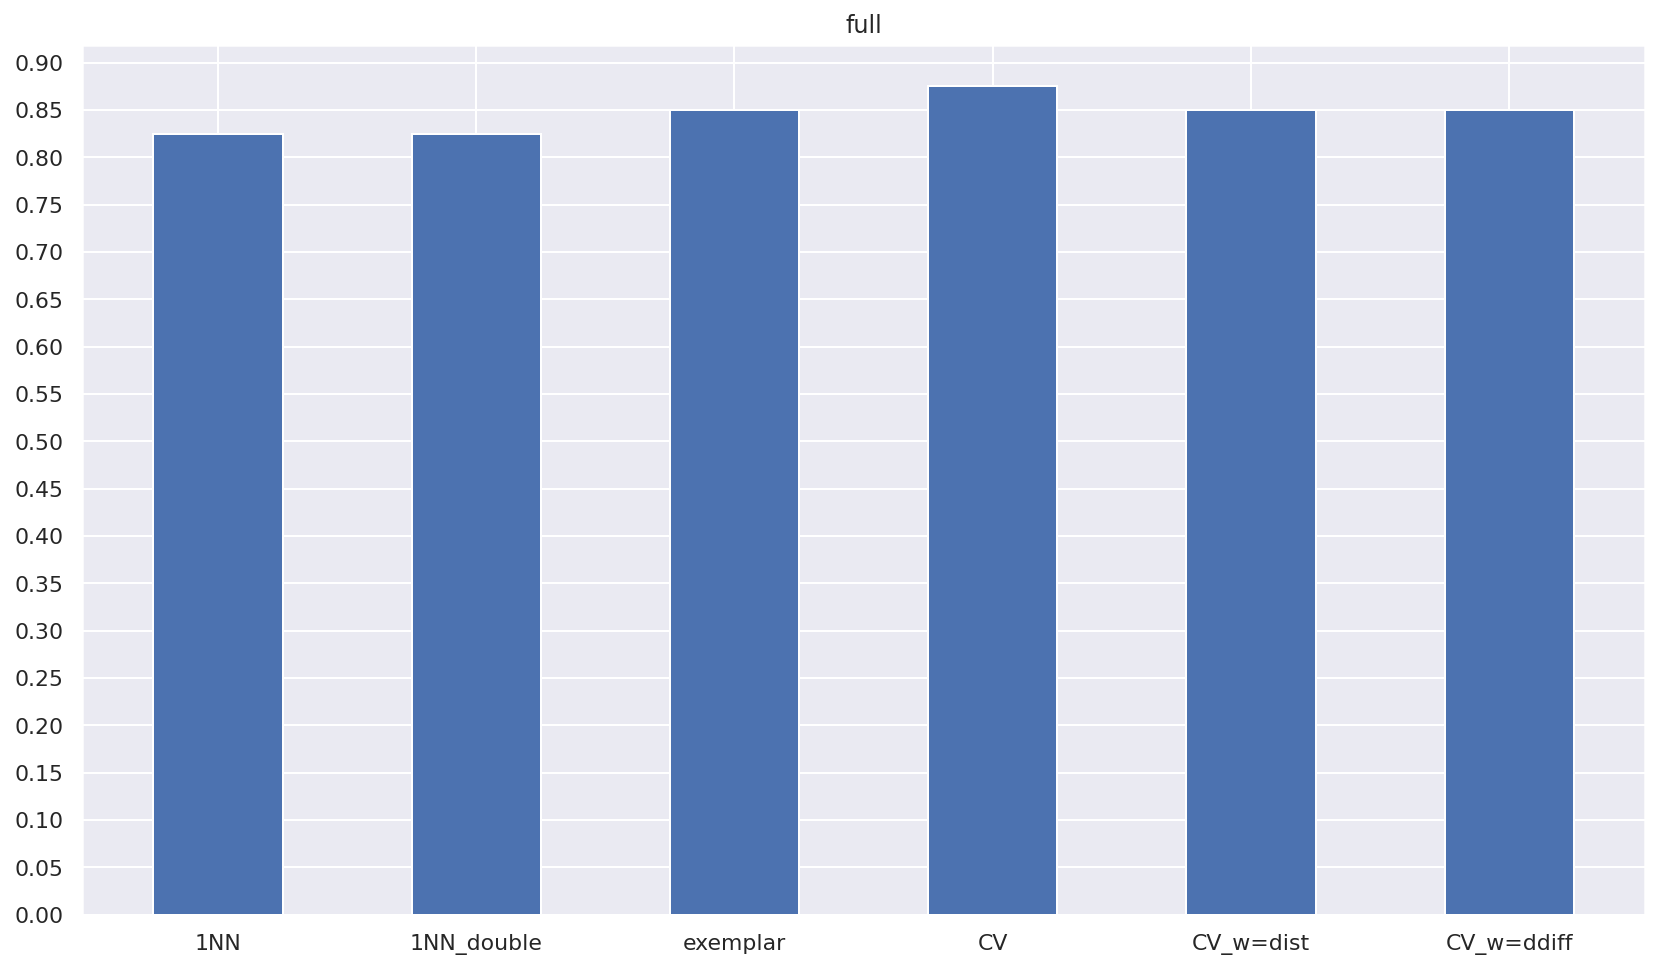

In [7]:
plot_full(full_results, m_range, "full")

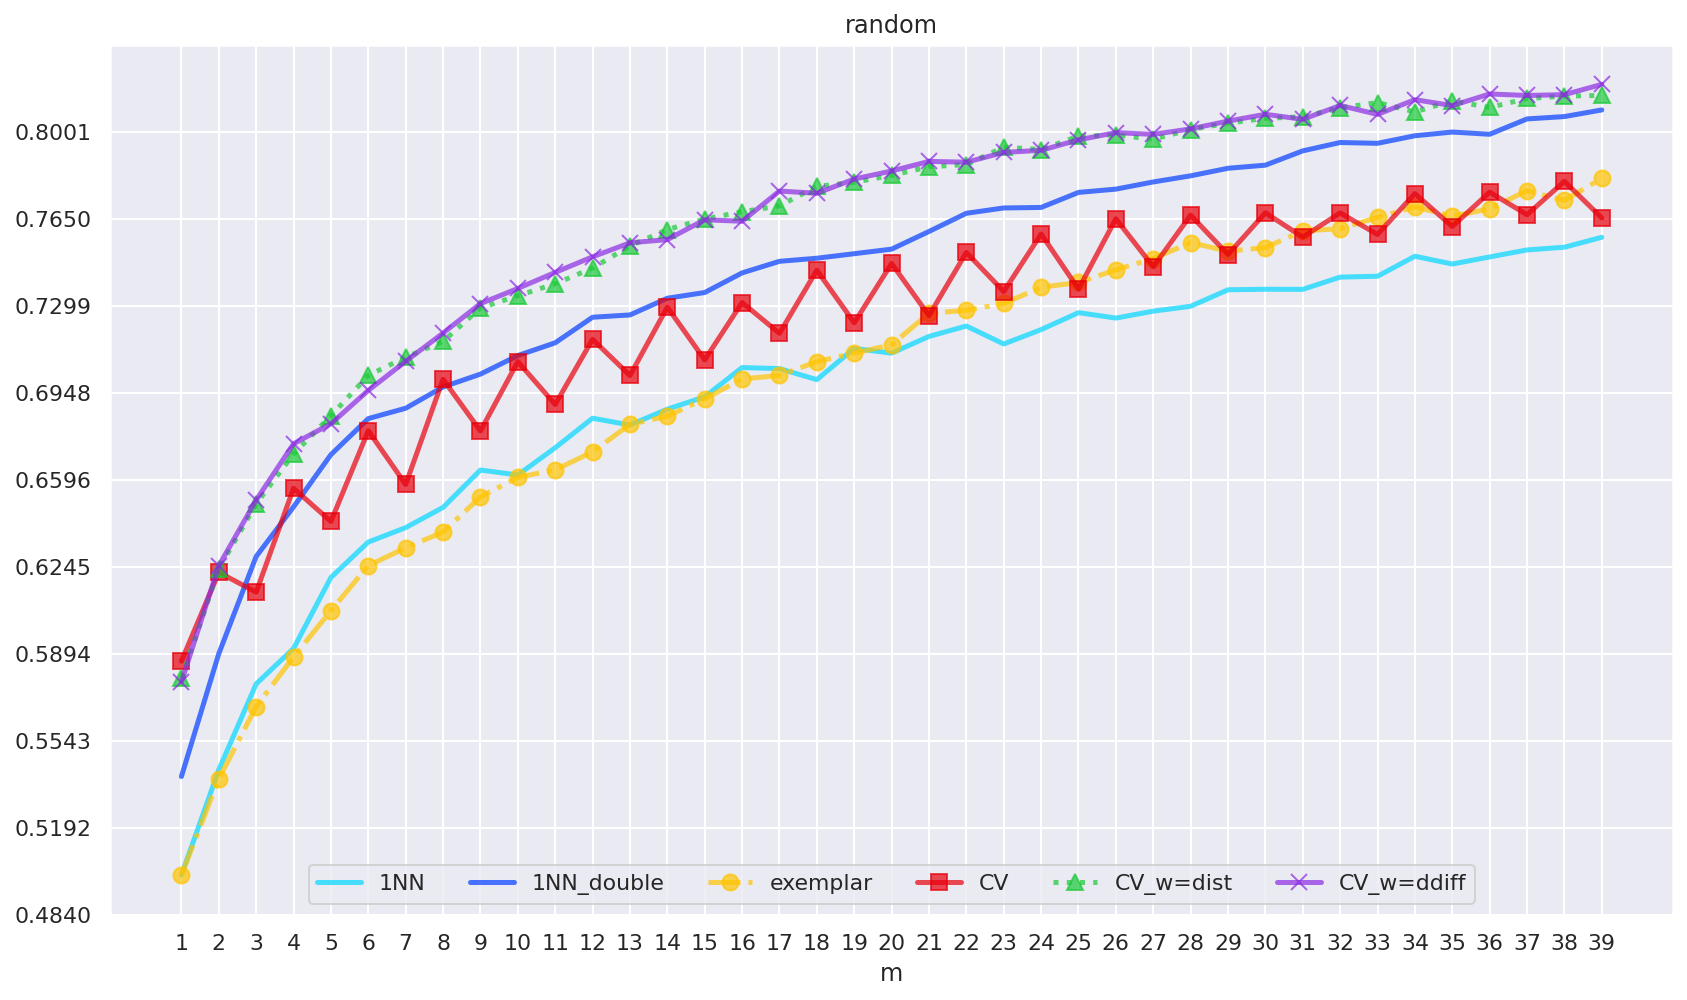

In [43]:
plot_random(random_results, m_range, "random")

In [10]:
stats.ttest_ind(random_results['CV_w=ddiff'], random_results['1NN_double'])

Ttest_indResult(statistic=1.0866865900989906, pvalue=0.29009934634946344)

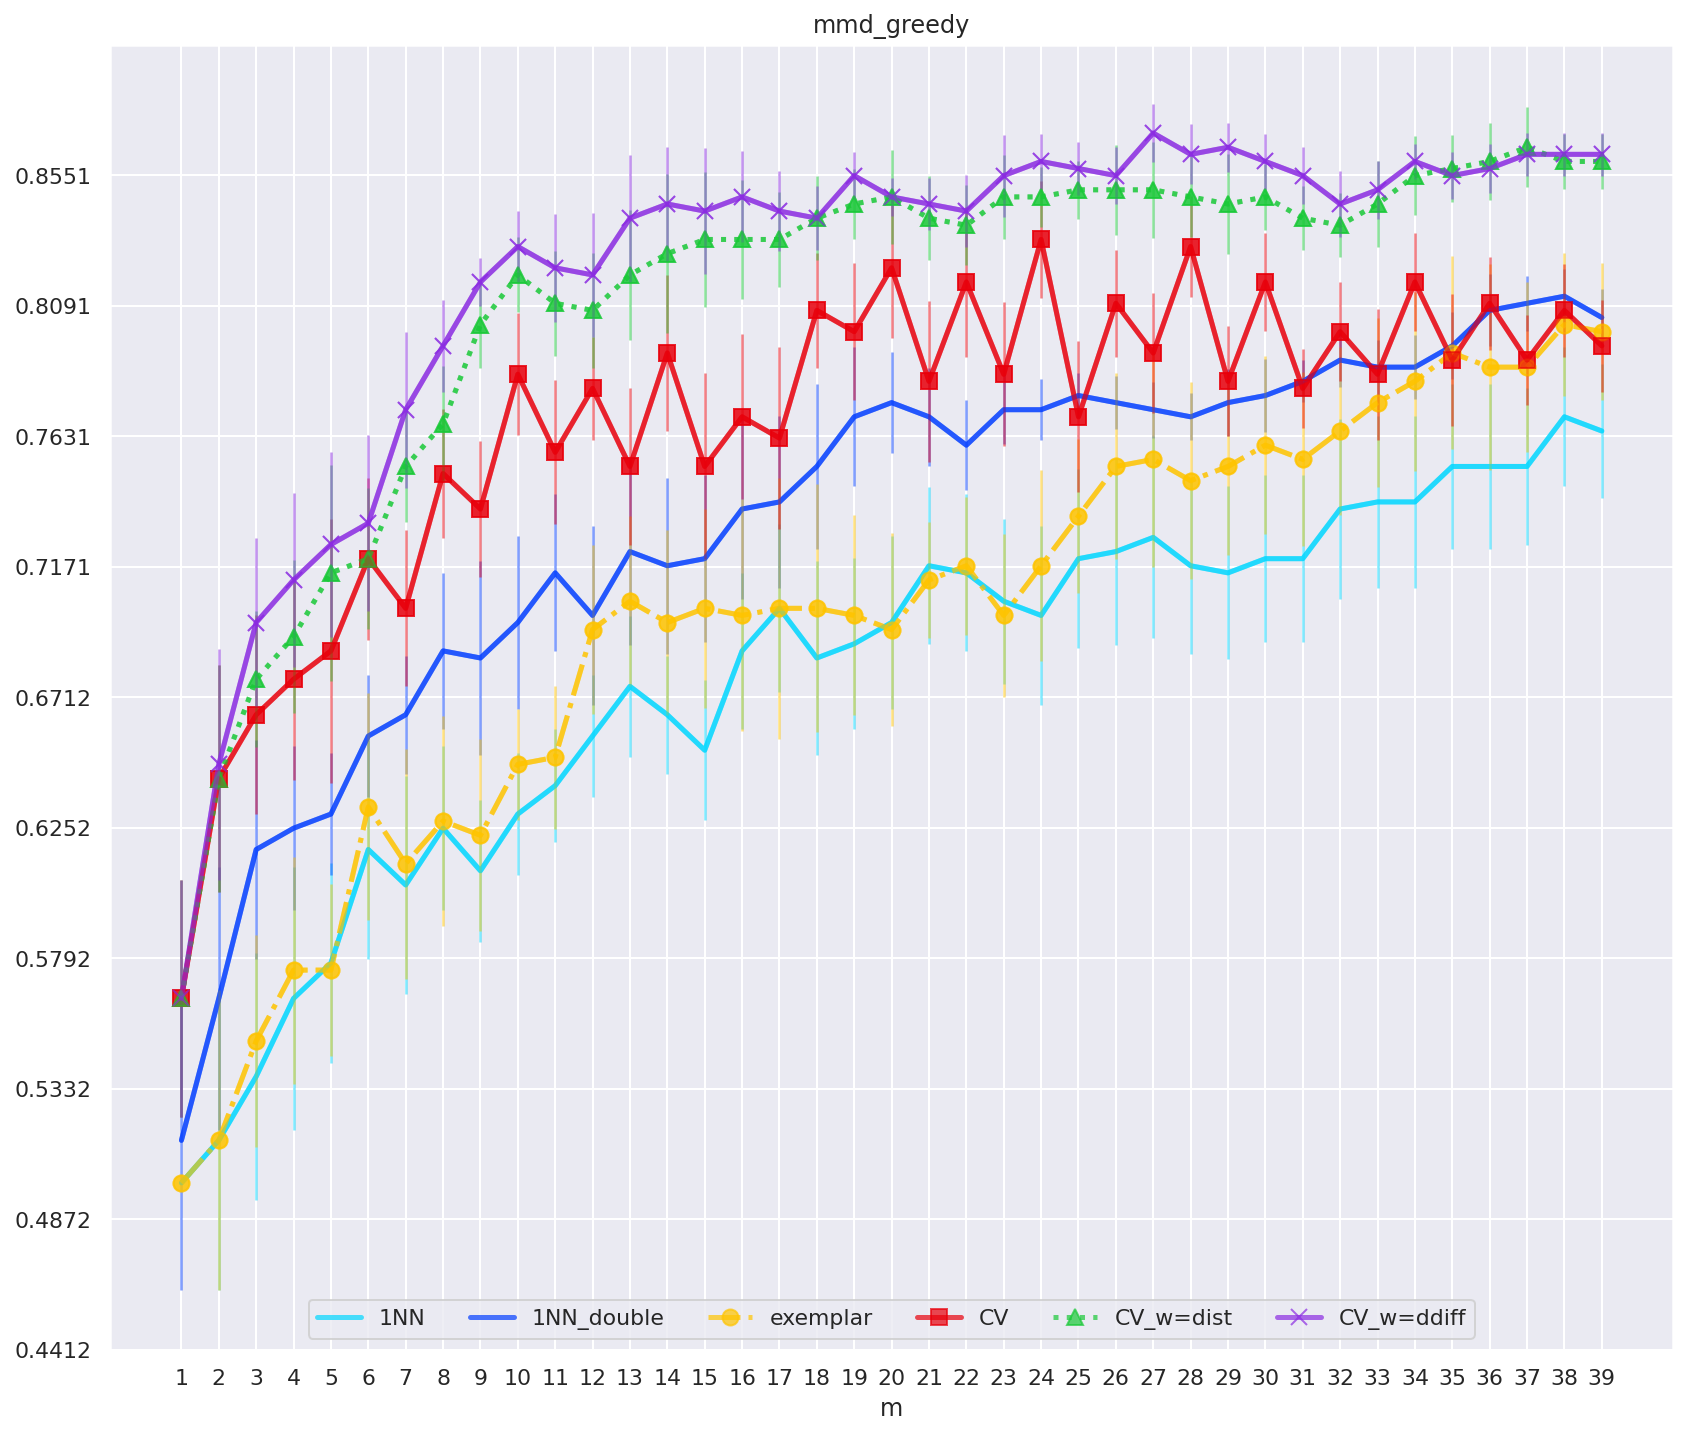

In [48]:
plot_teaching(teaching_acc, m_range, "mmd_greedy", ste=teaching_ste)

In [33]:
stats.ttest_ind(teaching_acc['CV_w=ddiff'], teaching_acc['1NN_double'])


Ttest_indResult(statistic=5.5684861881645675, pvalue=3.7105208724582837e-07)

In [56]:
dataset = "bm"
seeds = np.arange(10)
dist_Ms, zs, y_train, y_test = get_prolific_data(dataset, seeds)
paired_zs = [concat_embeds(z, y_train) for z in zs]

teaching_results = [teaching_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z, dist_M in zip(paired_zs, zs, dist_Ms)]
teaching_acc = {key:np.mean(np.array([result[key] for result in teaching_results]), axis=0) for key in teaching_results[0].keys()}
teaching_ste = {key: get_ci(np.array([result[key] for result in teaching_results])) for key in teaching_results[0].keys()}

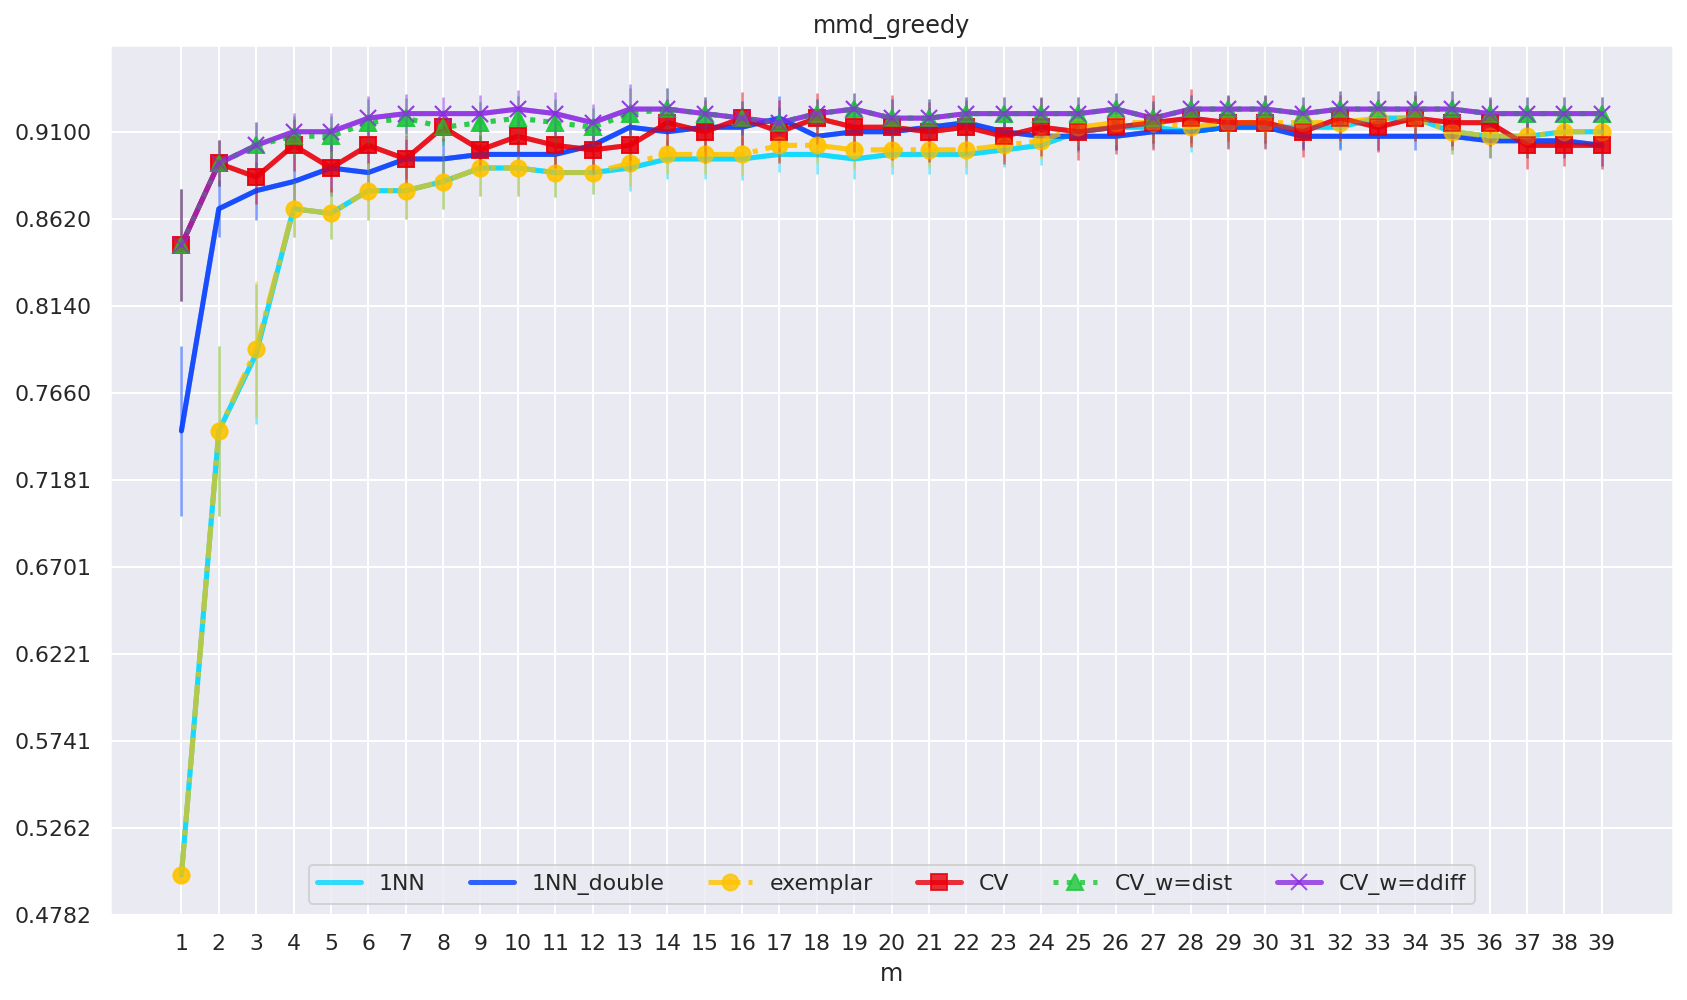

In [59]:
plot_teaching(teaching_acc, m_range, "mmd_greedy", ste=teaching_ste)

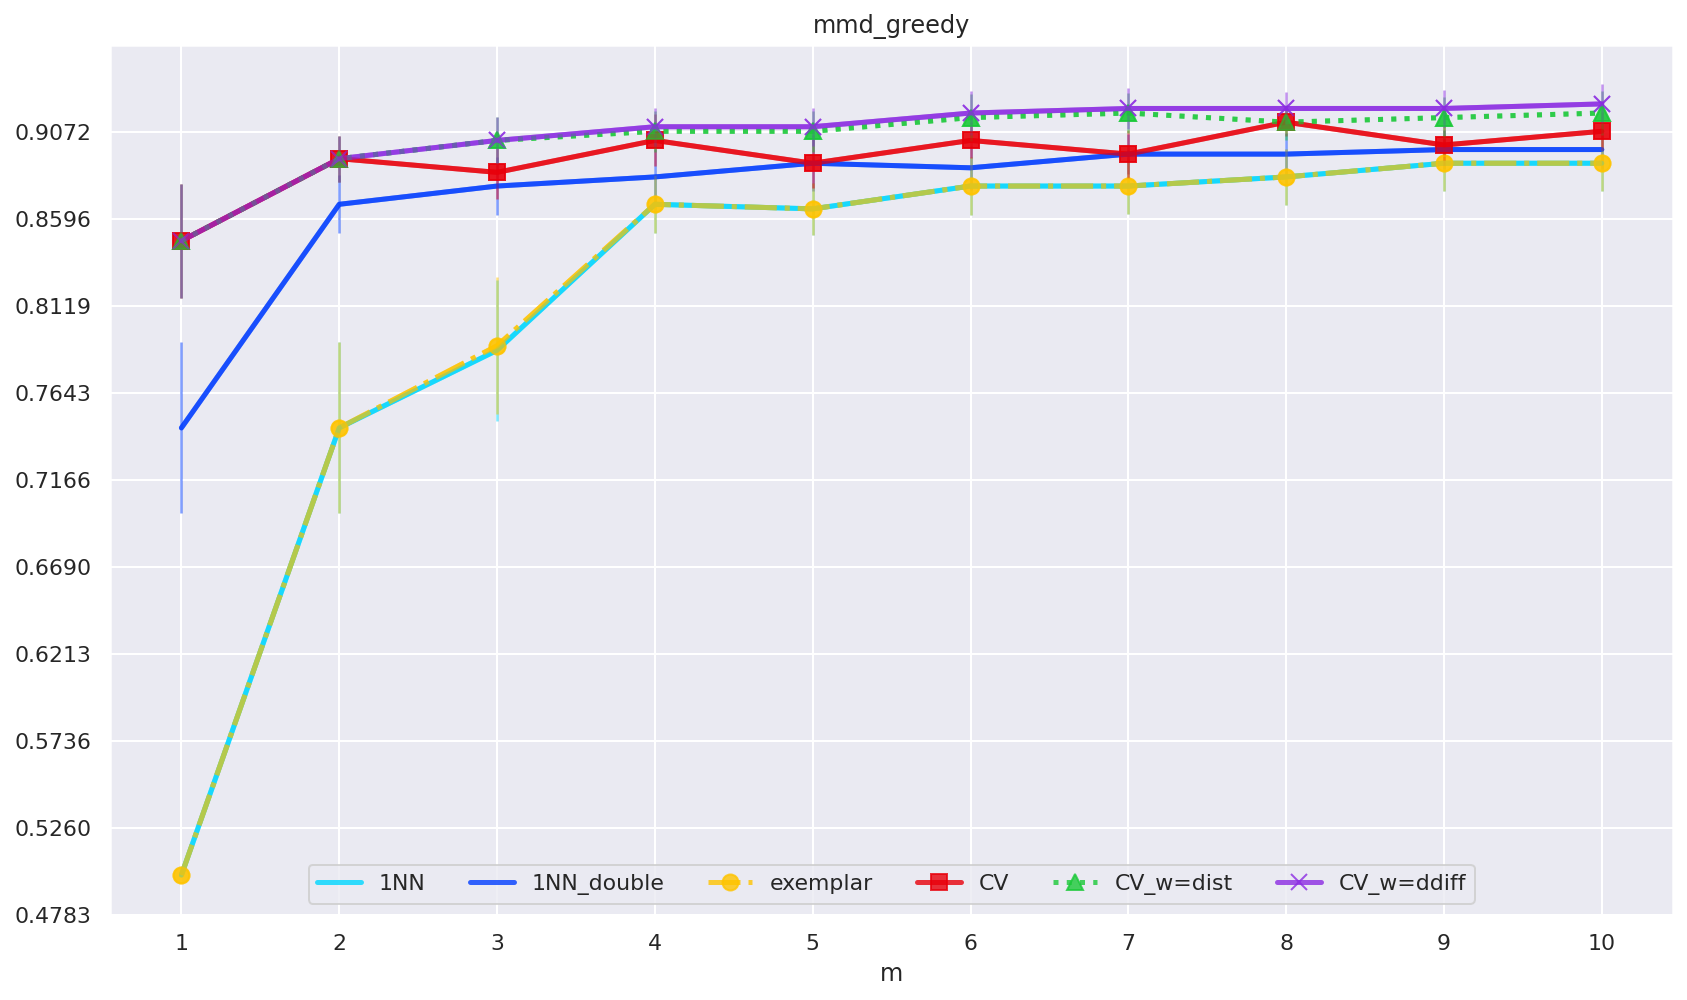

In [67]:
plot_teaching(teaching_acc, m_range, "mmd_greedy", ste=teaching_ste, idx=np.arange(10))


#### fixed learner

In [68]:
dataset = "bm"
seeds = np.arange(10)
SIM = True
dist_M, zs, y_train, y_test = get_lpips_data(dataset, seeds, sim=SIM)

In [94]:
full_acc = full_1NN(m_range, dist_M, y_train, y_test, sim=SIM)
random_acc = random_1NN(m_range*2, dist_M, y_train, y_test, sim=SIM)
teaching_results = np.array([[eval_KNN(dist_M, alg(z, m*2), y_train, y_test, sim=SIM) for m in m_range] for z in zs])
teaching_acc = teaching_results.mean(axis=0)
teaching_ste = [get_ci(col) for col in teaching_results.transpose()]

In [92]:
def plot_full_rand_teach(full, random, teach, m_range, alg, title, ste=None):
    configs = {     "full":          {'color': "k", 'lw': 2, 'ls':"dashed", 'marker': ""}, 
                    "random":        {'color': "y", 'lw': 2, 'ls':"dashed", 'marker': ""},
                    "teach":        {'color': "r", 'lw': 4, 'ls':"solid", 'marker': "^", 'ms':10},
    }

    sns.set_color_codes("bright")
    plt.figure(figsize=(14,8))
    plt.plot(m_range, full, alpha=0.8, **configs['full'])
    plt.plot(m_range, random, alpha=0.8, **configs['random'])
    plt.plot(m_range, teach, alpha=0.8, **configs['teach'])
    if ste is not None:
        yerr = ste
        plt.errorbar(m_range, teach, yerr=yerr, alpha=0.5, elinewidth=configs['teach']['lw']/2, **configs['teach'])


    plt.xticks(m_range)
    plt.xlabel("m")
    plt.legend(['full', 'random', alg], loc="lower center", ncol=len(configs))
    plt.title(title)
    # if SAVE_FIG:
    #     plt.savefig(f"{title}.pdf")
    # else:
    #     plt.show()

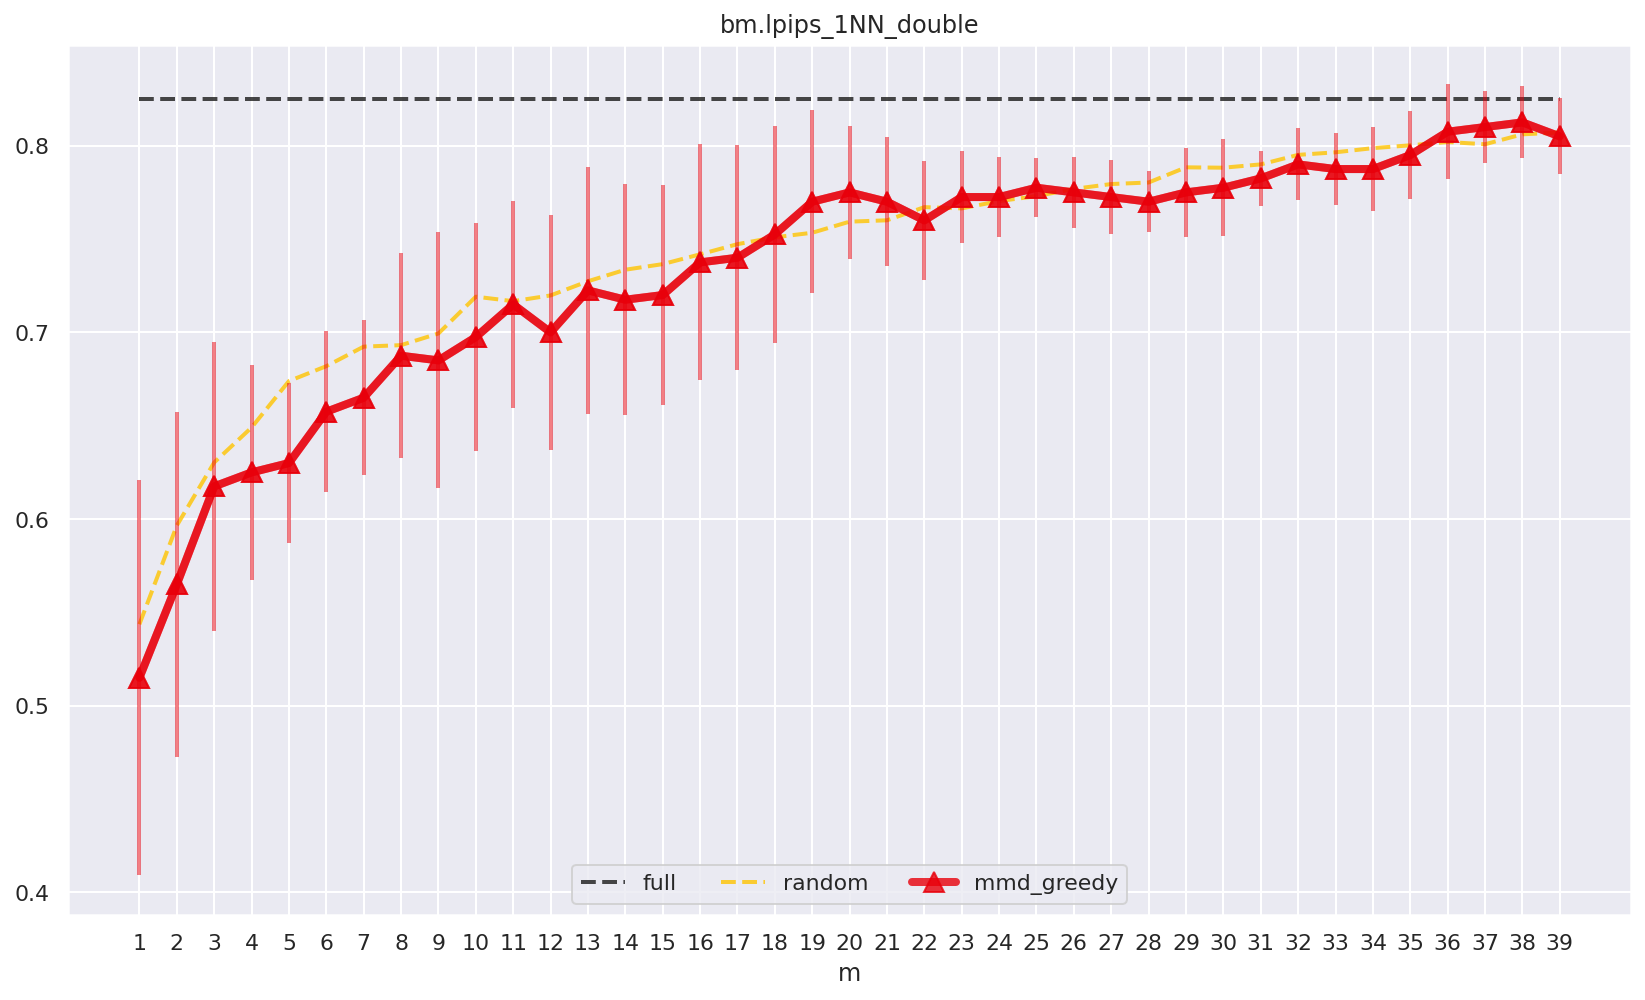

In [95]:
plot_full_rand_teach(full_acc, random_acc, teaching_acc, m_range, 'mmd_greedy', "bm.lpips_1NN_double", teaching_ste)

### DIFF vs. CONCAT

In [11]:
def plot_concat_diff(concat_acc, diff_acc, m_range, title):
    legend = ['CV_CONCAT', 'CV_DIFF', 'wCV_CONCAT', 'wCV_DIFF', 'CV_abs_CONCAT', 'CV_abs_DIFF']
    configs = {
                    "CV_scores":            ["r", 4, "s", "dashdot"],
                    "wCV_scores":           ["g", 4, "^", "dotted"],
                    "CV_abs_scores":        ["m", 4, "x", "solid"]}

    sns.set_color_codes("bright")
    plt.figure(figsize=(14,8))
    for score in concat_acc.keys():
        config = configs[score]
        _ = plt.plot(m_range, concat_acc[score], alpha=0.8,
        color=config[0], lw=config[1],linestyle="solid")
        _ = plt.plot(m_range, diff_acc[score], alpha=0.8,
        color=config[0], lw=config[1],linestyle="dotted")


    plt.xticks(m_range)
    plt.xlabel("m")
    plt.legend(legend, loc="lower center", ncol=len(concat_acc))
    plt.title(title)

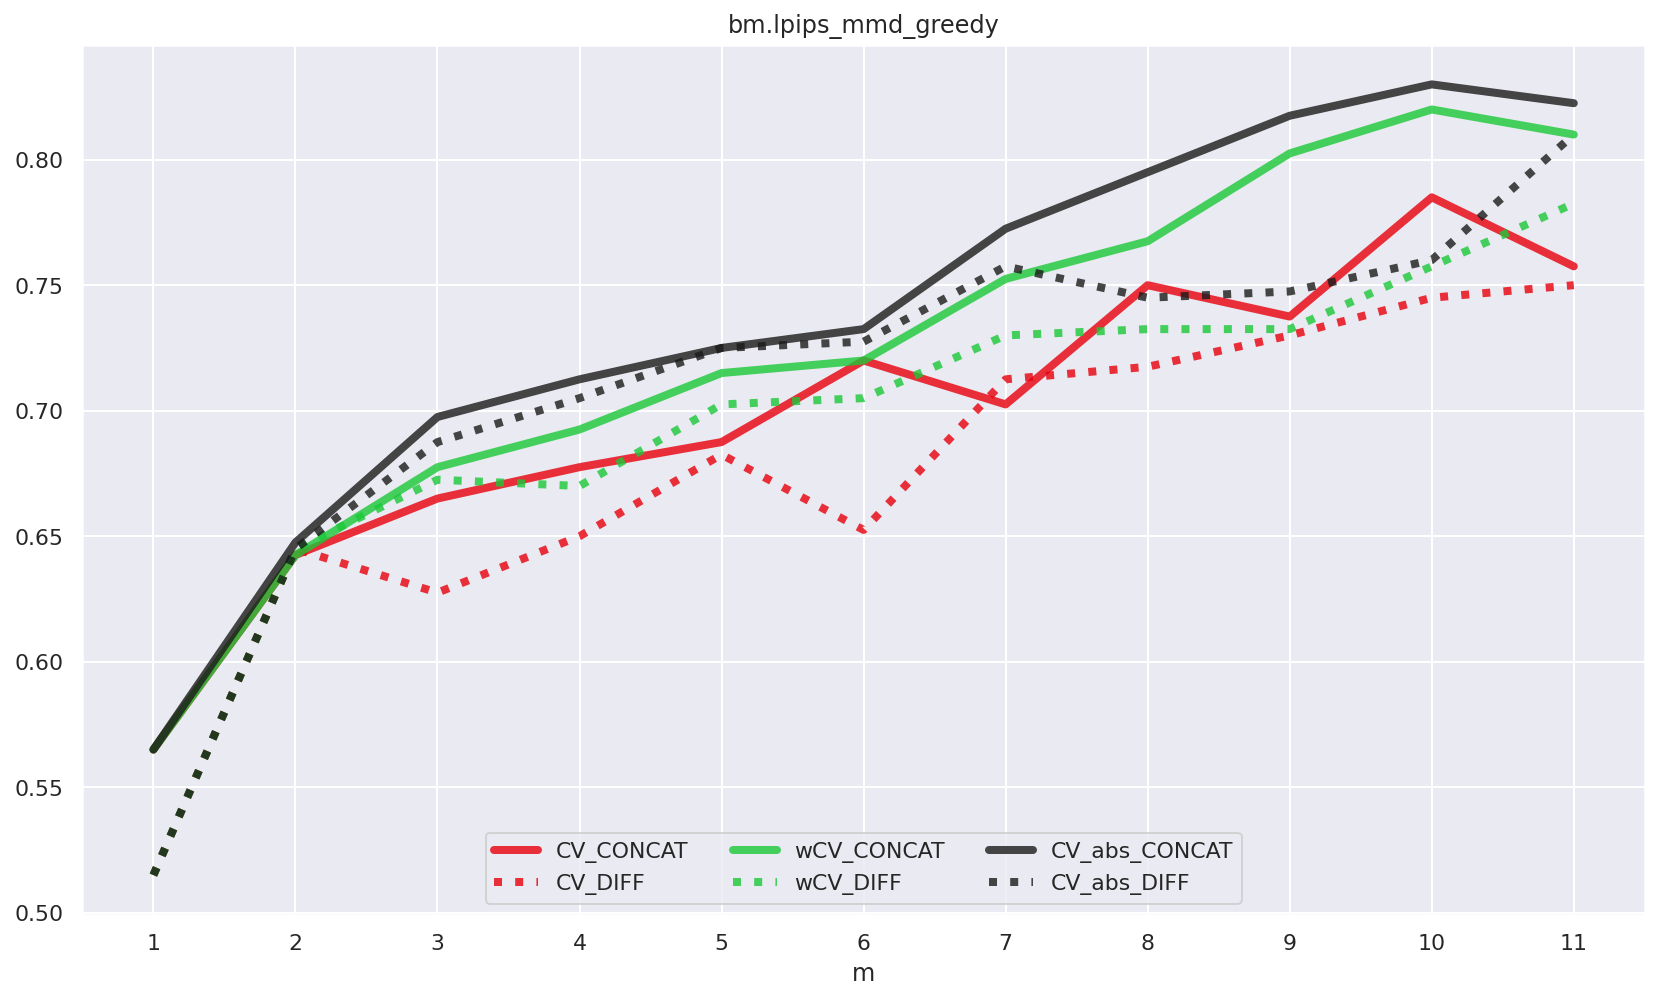

In [7]:
dataset = "bm"
seeds = np.arange(10)
dist_M, zs, y_train, y_test = get_lpips_data(dataset, seeds)
concat_zs = [evals.concat_embeds(z, y_train) for z in zs]
diff_zs = [evals.diff_embeds(z, y_train) for z in zs]

for alg, alg_name in zip(teaching_algs, alg_names):
    concat_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z in zip(concat_zs, zs)]
    diff_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z in zip(diff_zs, zs)]
    concat_acc = {key:np.mean(np.array([result[key] for result in concat_results]), axis=0) for key in concat_results[0].keys()}
    diff_acc = {key:np.mean(np.array([result[key] for result in diff_results]), axis=0) for key in diff_results[0].keys()}
    plot_concat_diff(concat_acc, diff_acc, m_range, f"{dataset}.lpips_{alg_name}")

11


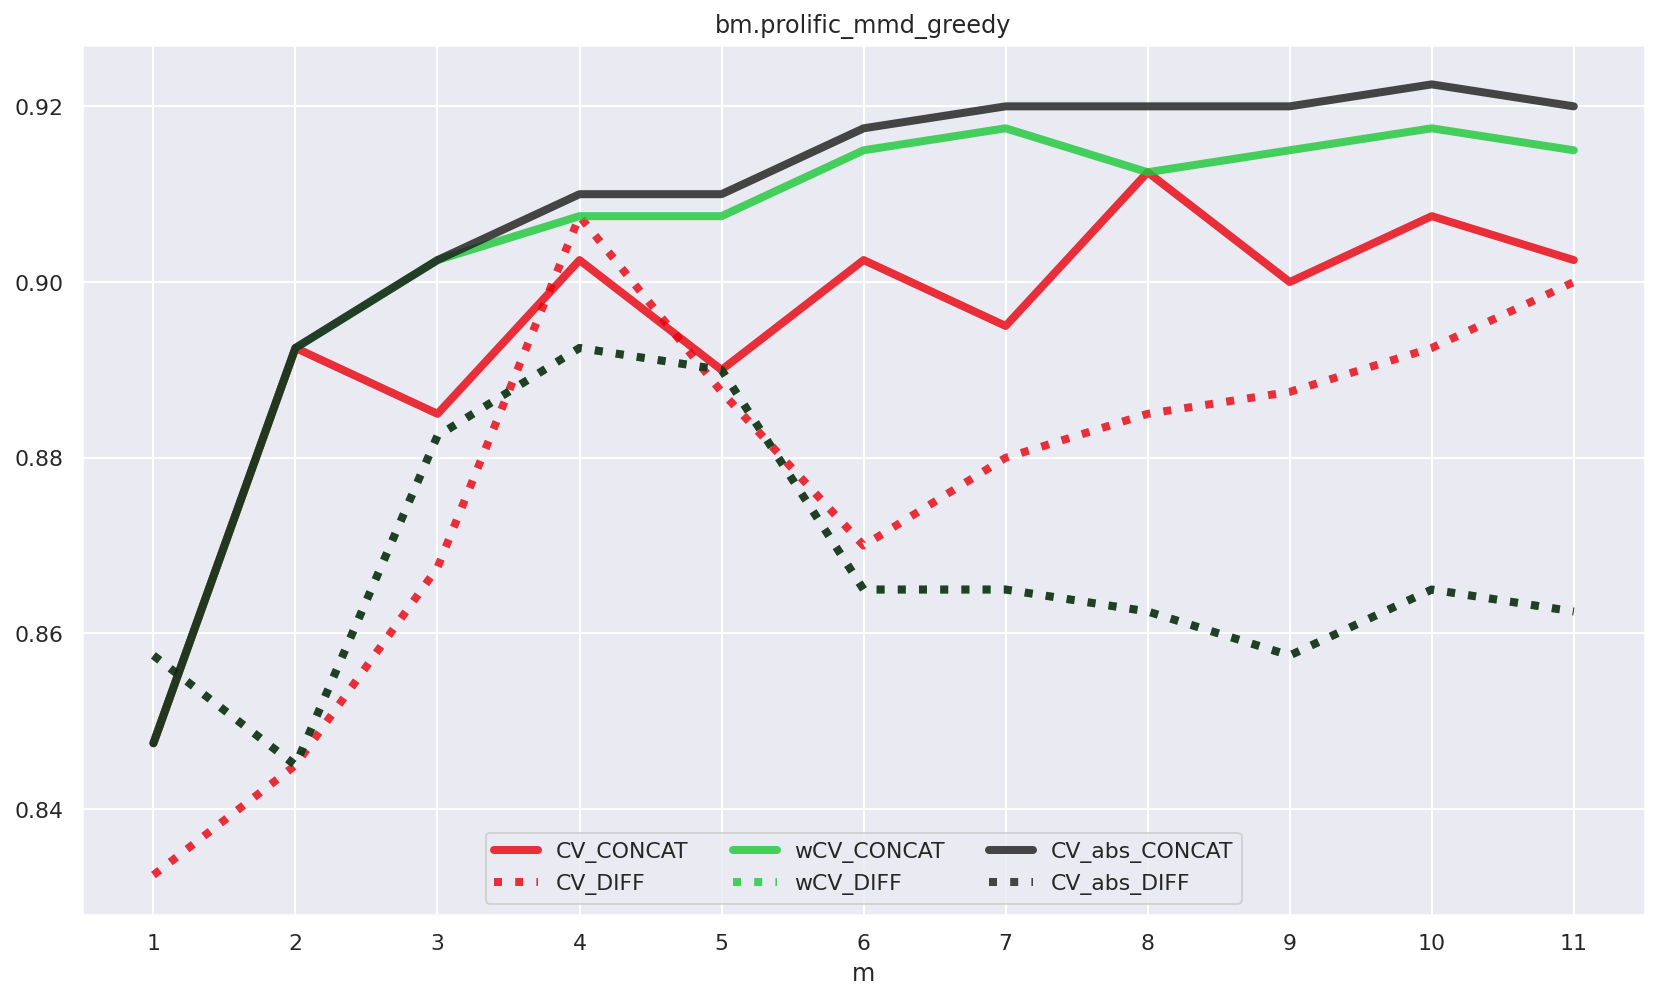

In [8]:
dataset = "bm"
seeds = np.arange(10)
dist_Ms, zs, y_train, y_test = get_prolific_data(dataset, seeds)
concat_zs = [evals.concat_embeds(z, y_train) for z in zs]
diff_zs = [evals.diff_embeds(z, y_train) for z in zs]

for alg, alg_name in zip(teaching_algs, alg_names):
    concat_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z, dist_M in zip(concat_zs, zs, dist_Ms)]
    print(11)
    diff_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z, dist_M in zip(diff_zs, zs, dist_Ms)]
    concat_acc = {key:np.mean(np.array([result[key] for result in concat_results]), axis=0) for key in concat_results[0].keys()}
    diff_acc = {key:np.mean(np.array([result[key] for result in diff_results]), axis=0) for key in diff_results[0].keys()}
    plot_concat_diff(concat_acc, diff_acc, m_range, f"{dataset}.prolific_{alg_name}")

In [10]:
diff_acc

{'CV_scores': array([0.8325, 0.845 , 0.8675, 0.9075, 0.8875, 0.87  , 0.88  , 0.885 ,
        0.8875, 0.8925, 0.9   ]),
 'wCV_scores': array([0.8575, 0.845 , 0.8825, 0.8925, 0.89  , 0.865 , 0.865 , 0.8625,
        0.8575, 0.865 , 0.8625]),
 'CV_abs_scores': array([0.8575, 0.845 , 0.8825, 0.8925, 0.89  , 0.865 , 0.865 , 0.8625,
        0.8575, 0.865 , 0.8625])}